In [1]:
%matplotlib inline
import json
import numpy as np
from scipy.spatial.distance import cdist, euclidean
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
pth = 'D:\\Dropbox\\research\\SFARI_MARS\\AMT_reannotation\\datasets'
fidWhite = os.path.join(pth,'white_1000\\white_mouse_1000_output.manifest')
fidBlack = os.path.join(pth,'white_1000\\black_mouse_1000_output.manifest')

# first read the json for each mouse:
data = {'white':[],'black':[]}
for line in open(fidWhite,'r'):
    data['white'].append(json.loads(line))

for line in open(fidBlack,'r'):
    data['black'].append(json.loads(line))


In [3]:
nSamp   = len(data['white'])
nKpts   = 7
order   = ['nose','right ear','left ear','top of neck','right rear knee','left rear knee','base of tail']
DOLOCAL = True              # replace the path to the image in the s3 bucket with a path to its location on the local machine
keyName = 'annotatedResult' # name for the dict containing annotation data- this was set in run_labeling_job

rawPts      = {'white':[],'black':[]}
images      = {'white':[],'black':[]}
hits        = {'white':[],'black':[]}
workerCount = {'white':[],'black':[]}

for mouse in ['white','black']:
    rawPts[mouse] = np.zeros((nSamp,nKpts,2,6)) # for each image: 7 keypoints, 2 dimensions, 6 workers per keypoint
    images[mouse] = ['']*nSamp        # track paths to labeled images
    hits[mouse] = [False]*nSamp       # track which images have annotations (only needed if a job failed to complete)
    workerCount[mouse] = [0]*nSamp    # track the number of workers who labeled each image (only needed if a job failed to complete)

    sourceStr = os.path.dirname(data[mouse][0]['source-ref'])
    pth = 'D:\\Dropbox\\research\\SFARI_MARS\\AMT_reannotation\\datasets\\{}_1000\\'.format(mouse)
    
    for f,frame in enumerate(data[mouse]):
        if (keyName in frame.keys()): #check if this frame has at least one set of annotations
            hits[mouse][f] = True

            images[mouse][f] = frame['source-ref']
            if DOLOCAL:
                images[mouse][f] = images[mouse][f].replace(sourceStr,pth) # load from local path

            for w,worker in enumerate(frame[keyName]['annotationsFromAllWorkers']):
                workerCount[mouse][f] = workerCount[mouse][f] + 1

                # the json of annotations from each worker is stored as a string for security reasons.
                # we'll use eval to convert it into a dict:
                annot = eval(worker['annotationData']['content'])

                # now we can unpack this worker's annotations for each keypoint:
                for pt in annot[keyName]['keypoints']:
                    idx = order.index(pt['label'])
                    rawPts[mouse][f,idx,0,w] = pt['x']
                    rawPts[mouse][f,idx,1,w] = pt['y']


In [4]:
# we're going to set our ground-truth points as the geometric median of all the annotators.
# This algorithm for the geometric median comes from Vardi and Zhang 1999, as implemented by orlp on Stack Overflow
# (https://stackoverflow.com/questions/30299267/geometric-median-of-multidimensional-points)

def geometric_median(X, eps=1e-5):
    y = np.mean(X, 0)

    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1

        y = y1

In [5]:
# now let's get our ground-truth keypoints:

gtPts  = {'white':[],'black':[]}
allPts = {'white':[],'black':[]}

for mouse in ['white','black']:
    #first we'll take medians of the raw keypoints:
    gtPts[mouse] = np.zeros((nSamp,nKpts,2))
    for f,frame in enumerate(rawPts[mouse]):
        for p,pt in enumerate(frame):
            gtPts[mouse][f,p,:] = geometric_median(np.squeeze(pt.T))

    # then we'll adjust L/R assignments to try to find better median estimates. Iterating
    # seems to help settle on better final keypoints if the initial guesses were especially bad.
    for rep in range(3):
        # for ears and hips we should check for + correct Left/Right swaps, a common annotator mistake:
        allPts[mouse] = np.copy(rawPts[mouse])
        
        for fr,(gt,frame) in enumerate(zip(gtPts[mouse],rawPts[mouse])):
            for w,worker in enumerate(frame.swapaxes(0,2).swapaxes(1,2)):
                
                dEar1 = cdist(worker[1:3,:],[gt[1]])
                dEar2 = cdist(worker[1:3,:],[gt[2]])
                if (dEar1[0]>dEar1[1]) and (dEar2[1]>dEar1[0]):
                    allPts[mouse][fr,1,:,w] = rawPts[mouse][fr,2,:,w]
                    allPts[mouse][fr,2,:,w] = rawPts[mouse][fr,1,:,w]
                
                dHip1 = cdist(worker[4:6,:],[gt[4]])
                dHip2 = cdist(worker[4:6,:],[gt[5]])
                if (dHip1[0]>dHip1[1]) and (dHip2[1]>dHip2[0]):
                    allPts[mouse][fr,4,:,w] = rawPts[mouse][fr,5,:,w]
                    allPts[mouse][fr,5,:,w] = rawPts[mouse][fr,4,:,w]

        # then re-compute the medians:
        gtPts[mouse] = np.zeros((nSamp,nKpts,2))
        for f,frame in enumerate(allPts[mouse]):
            for p,pt in enumerate(frame):
                gtPts[mouse][f,p,:] = geometric_median(np.squeeze(pt.T))

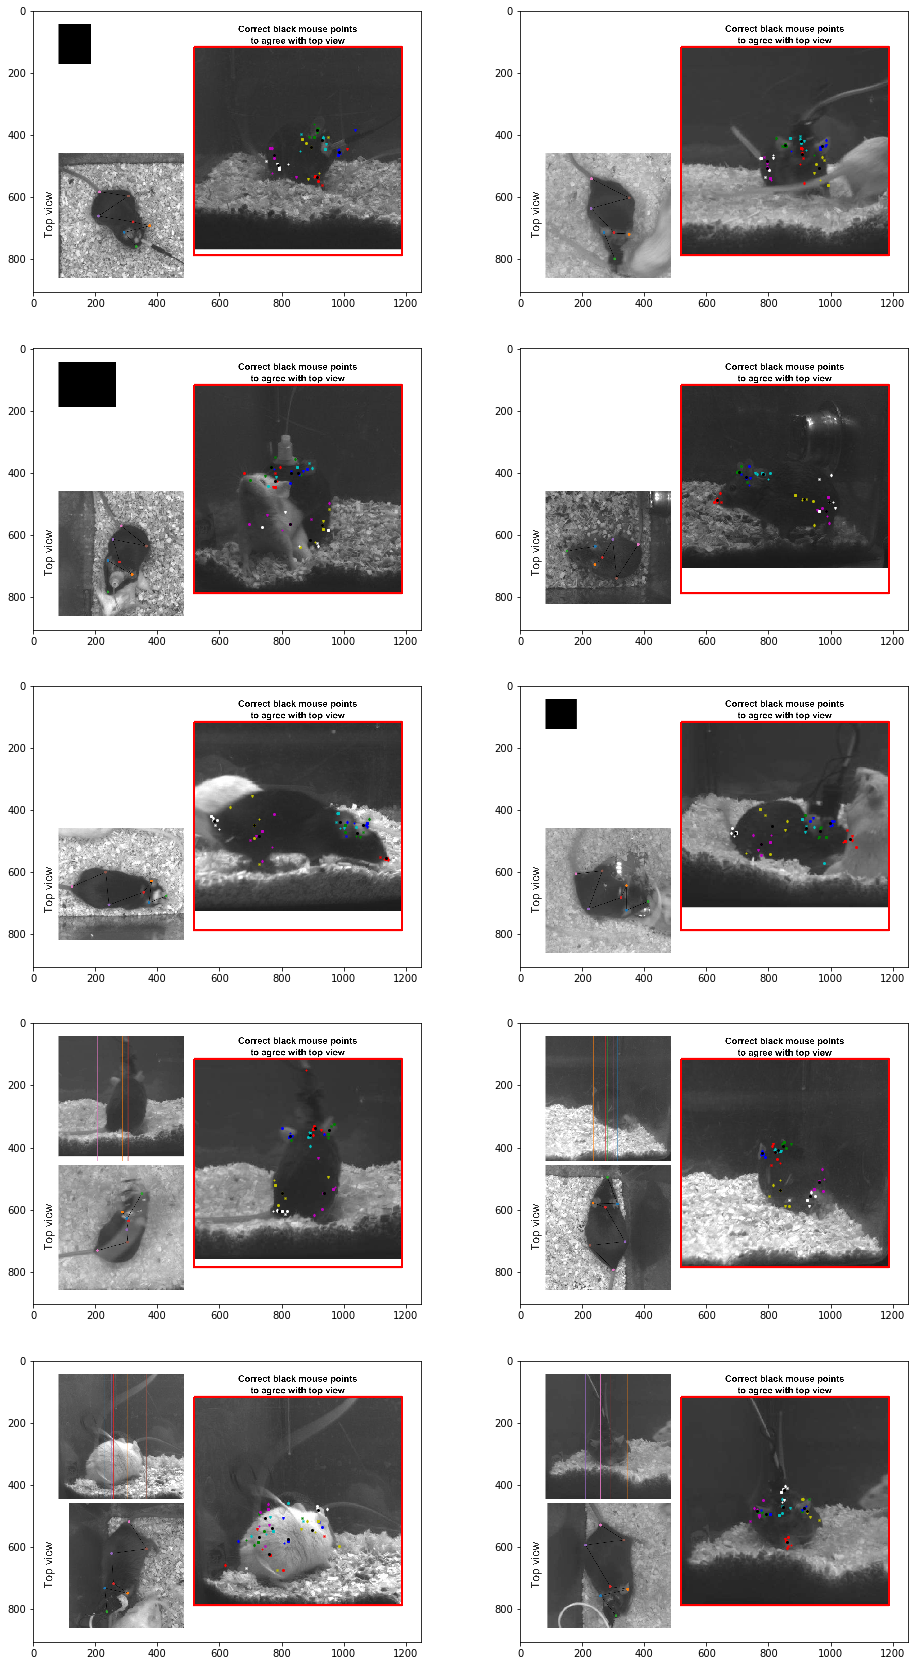

In [25]:
# let's look at a couple example images to see how our annotators did:
colors  = 'rgbcmyw'
markers = 'v+xosd'
mouse   = 'black'

fig,ax = plt.subplots(5,2,figsize=(16, 30))
for fr in range(0,10):
    im = mpimg.imread(images[mouse][fr])
    ax[int(fr/2),(fr+1)%2].imshow(im);
    
    # plot the labels from each individual worker:
    for p,pt in enumerate(np.squeeze(allPts[mouse][fr,...])):
        for w in range(6):
            ax[int(fr/2),(fr+1)%2].plot(pt[0,w], pt[1,w],colors[p] + markers[w], markersize=2)
    
    # plot the "ground truth" labels:
    ax[int(fr/2),(fr+1)%2].plot(gtPts[mouse][fr,:,0], gtPts[mouse][fr,:,1],'k.', markersize=4)
        
# fig.savefig(os.path.join('sample_data','generated_figures','white-mouse-test-100.pdf'), bbox_inches='tight')

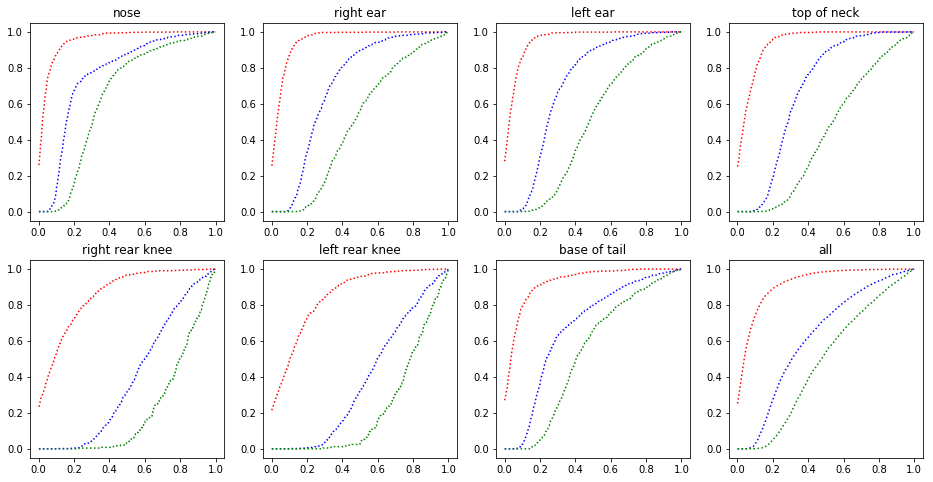

In [7]:
# now we'd like to quantify annotator variability. For some reason, this seems to be a good predictor
# of how well our pose estimator is going to do once trained.

pixels_per_cm = 54.378 # this is a little higher than the raw behvaior videos, because we zoomed in on the mouse to be labeled

fig,ax = plt.subplots(2,4,figsize=(16, 8))
dashes = {'white':'dotted', 'black':'dashed', 'both':'solid'}
colors = 'rbg'

for mouse in ['white','black','both']:
    if mouse != 'both':
        dMean = np.zeros((nKpts,nSamp)) # average worker-gt distance
        dMin  = np.zeros((nKpts,nSamp)) # performance of best worker on a given frame
        dMax  = np.zeros((nKpts,nSamp)) # performance of worst worker on a given frame
        for fr,(gt,est) in enumerate(zip(gtPts[mouse],allPts[mouse])):
            for pt,(gtPt,estPts) in enumerate(zip(gt,est)):
                D = cdist(estPts.T, [gtPt]) / pixels_per_cm
                dMean[pt,fr] = np.mean(D)
                dMin[pt,fr]  = min(D)
                dMax[pt,fr]  = max(D)
    else:
        dMean = np.zeros((nKpts,nSamp*2))
        dMin  = np.zeros((nKpts,nSamp*2))
        dMax  = np.zeros((nKpts,nSamp*2))
        for fr,(gt,est) in enumerate(zip(np.concatenate((gtPts['white'],gtPts['black'])), \
                                        np.concatenate((allPts['white'],allPts['black'])))):
            for pt,(gtPt,estPts) in enumerate(zip(gt,est)):
                D = cdist(estPts.T, [gtPt]) / pixels_per_cm
                dMean[pt,fr] = np.mean(D)
                dMin[pt,fr]  = min(D)
                dMax[pt,fr]  = max(D)

    binSize = 0.001
    bins = np.arange(0,3,binSize)

    for c,use in enumerate([dMin,dMean,dMax]):
        for p,pt in enumerate(use):
            counts,_ = np.histogram(pt,bins,density=True)
            ax[int(p/4),p%4].plot(bins[1:], counts.cumsum()*binSize, colors[c], ls=dashes[mouse])
            ax[int(p/4),p%4].set_title(order[p])

        counts,_ = np.histogram(use.ravel(),bins,density=True)
        ax[1,3].plot(bins[1:], counts.cumsum()*binSize, colors[c], ls=dashes[mouse])
        ax[1,3].set_title('all');

#     fig.savefig(os.path.join('sample_data','generated_figures','both-mouse-test-100_error_radii.pdf'), bbox_inches='tight')